In [19]:
%load_ext autoreload
%autoreload 2

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plume_learn.viz import show_images, label_violinplot
from plume_learn.analyzer.plume_utils import remove_all_0_plume
from plume_learn.analyzer.PlumeDataset import plume_dataset
from m3util.viz.layout import layout_fig
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Plume data

### 1.1 load experiment conditions

In [20]:
df_condition = pd.read_excel('../data/Sample log.xlsx', sheet_name='SRO')
df_condition = df_condition.loc[[27, 34, 35, 36, 37, 38, 39, 40], ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)
df_condition.replace('700 (heater N)', 700, inplace=True)
df_condition['Growth'] = df_condition['Growth'].str.replace(r'LYW_YCG', 'YG', regex=True)
df_condition.sample(5)

C:\Users\yig319\AppData\Local\Temp\ipykernel_56644\1382544829.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_condition.replace('700 (heater O)', 700, inplace=True)
C:\Users\yig319\AppData\Local\Temp\ipykernel_56644\1382544829.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_condition.replace('700 (heater N)', 700, inplace=True)


,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz)
35,YG064,100.0,700,1.6,5.0
36,YG065,100.0,700,1.6,5.0
39,YG068,100.0,700,1.6,5.0
40,YG069,100.0,700,1.6,6.6
38,YG067,100.0,700,1.6,5.0


### 1.2 load metrics for every plume frame

In [81]:
growth_names = ['YG065', 'YG066', 'YG067', 'YG068', 'YG069']

df_frame_metrics = []
for key in df_condition['Growth'].unique():
    file = glob.glob(f'../large_files/SRO_plume_metrics/{key}*metrics.csv')[0]
    # print(file)
    df = pd.read_csv(file, index_col=0)
    df['Threshold'].astype(str)
    df = df[df['Threshold']=='200']
    df = remove_all_0_plume(df.reset_index(), metric='Area', viz=False)
    df_frame_metrics.append(df)
    
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics = df_frame_metrics.replace('YG065', 'Sample 1')
df_frame_metrics = df_frame_metrics.replace('YG066', 'Sample 2')
df_frame_metrics = df_frame_metrics.replace('YG067', 'Sample 3')
df_frame_metrics = df_frame_metrics.replace('YG068', 'Sample 4')
df_frame_metrics = df_frame_metrics.replace('YG069', 'Sample 5')

df_frame_metrics['time_index'] = df_frame_metrics['time_index'] * 500e-3 # convert ns to ms
df_frame_metrics.rename(columns={'time_index': 'Time (µs)'}, inplace=True)
df_frame_metrics.rename(columns={'plume_index': 'Plume Index'}, inplace=True)
df_frame_metrics.rename(columns={'Area': 'Area (a.u.)'}, inplace=True)

df_frame_metrics['Distance'] = df_frame_metrics['Distance'] * 54/1000/347  # convert pixel to meter: target to substrate distance is 54mm or 347 pixels.
df_frame_metrics.rename(columns={'Distance': 'Distance (m)'}, inplace=True)
df_frame_metrics.rename(columns={'Velocity': 'Velocity (m/s)'}, inplace=True)

growth_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5']
df_frame_metrics_target = df_frame_metrics[df_frame_metrics['Growth'].isin(growth_names)]
df_frame_metrics_target.sample(5)

,Plume Index,Time (µs),Distance (m),Velocity (m/s),Area (a.u.),Threshold,Growth
269847,2,11.5,0.032991,0.0,0.0,200,Sample 4
343197,194,14.5,0.033303,0.0,0.0,200,Sample 5
326539,64,5.5,0.032991,0.0,3234.0,200,Sample 5
209761,292,48.5,0.031280,0.0,0.0,200,Sample 2
333107,115,25.5,0.033458,0.0,0.0,200,Sample 5


### 1.3 calculate max area and incident velocity

In [96]:
# analyze the max area
# df_frame_metrics_target_selected = df_frame_metrics_target[df_frame_metrics_target['Threshold']=='flexible']
idx = df_frame_metrics_target.groupby(['Growth', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics_target.loc[idx, ['Growth', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)
# df_max_area.sample(8)

# analyze plume Velocity that can be tracked before landing on the substrate
df_filtered = df_frame_metrics_target[(df_frame_metrics_target['Distance (m)'] >= 0.028) & (df_frame_metrics_target['Distance (m)'] <= 0.029)]
# df_filtered = df_frame_metrics_target
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Growth', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity (m/s)': 'Incident Velocity (m/s)'}, inplace=True)
# incident_Velocity.sample(8)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Growth', 'Plume Index'])
# df_plume_metrics.sample(8)

df_plume_metrics_target = df_plume_metrics[df_plume_metrics['Growth'].isin(growth_names)]
df_plume_metrics_target.sample(5)

,Growth,Plume Index,Time at Max Area (µs),Max Area (a.u.),Incident Velocity (m/s)
514,Sample 3,356,3.0,15640.0,40000000.0
743,Sample 5,176,3.0,16262.0,38000000.0
27,Sample 1,83,3.0,16874.0,38000000.0
473,Sample 3,276,3.0,16130.0,36000000.0
153,Sample 2,22,3.0,14375.0,26000000.0


## 2. Introduction to Plume Dynamics Analysis

### 2.1 Visualize Plume with Time

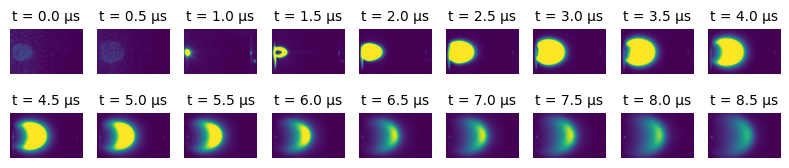

In [63]:
file = 'D:/pld_plumes/SRO_STO_Drexel/YG063_YichenGuo_08042024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
plumes = plume_ds.load_plumes('1-SrRuO3')
sample_frames = plumes[0][0:18]
labels = np.arange(len(sample_frames))*500e-3
labels = [f't = {l:.1f} µs' for l in labels]
fig, axes = layout_fig(18, mod=9, figsize=(8, 2), layout='tight')
show_images(sample_frames, labels=labels, img_per_row=9, title=None, fig=fig, axes=axes, label_size=10)
plt.show()

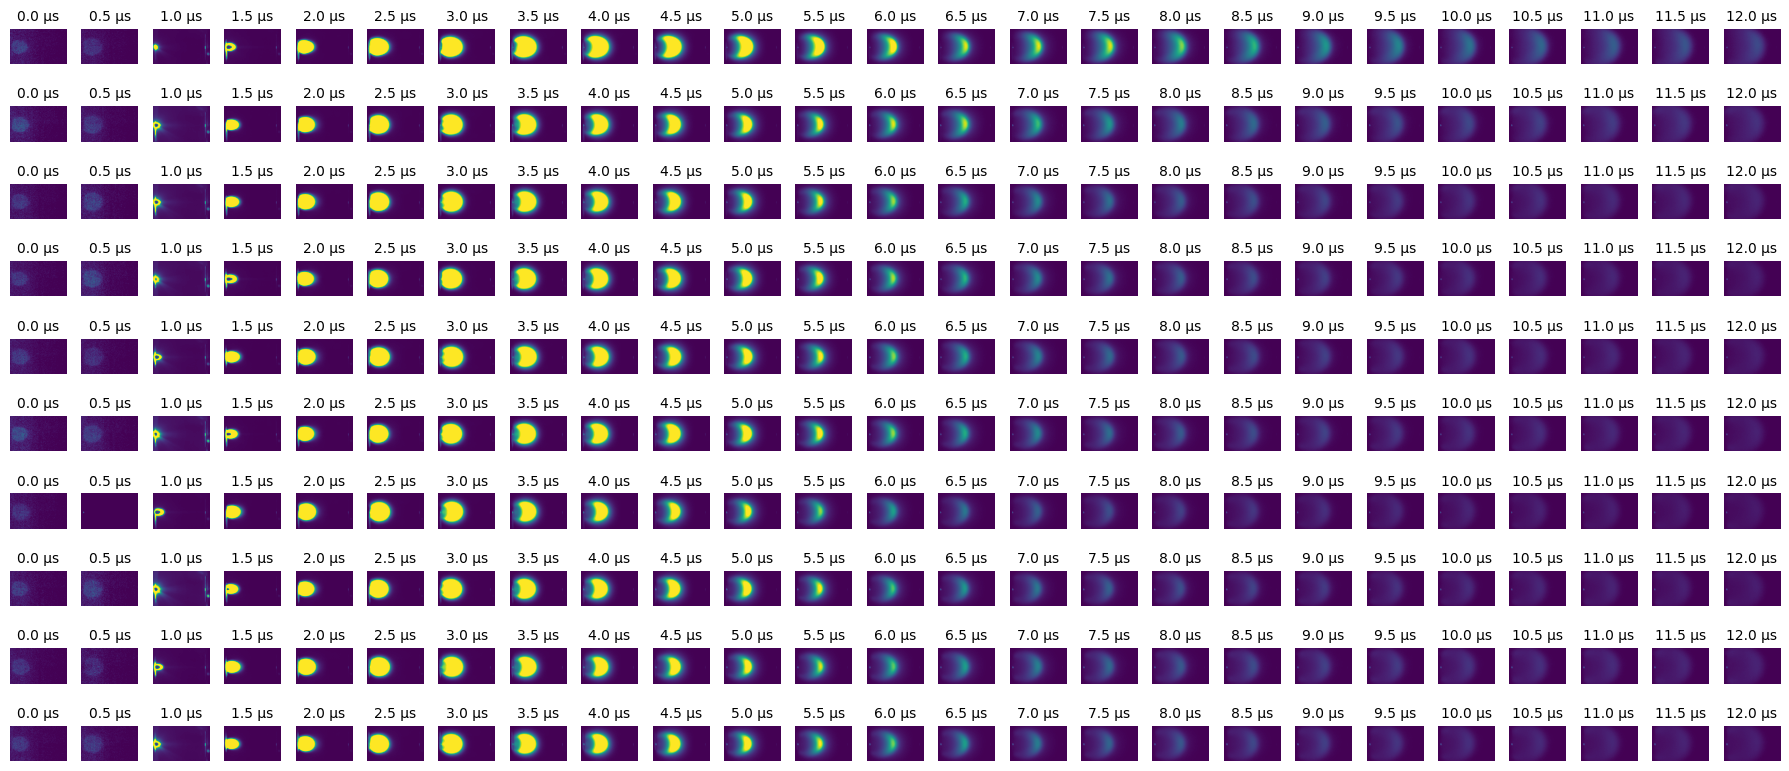

In [46]:
file = 'D:/pld_plumes/SRO_STO_Drexel/YG063_YichenGuo_08042024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
plumes = plume_ds.load_plumes('1-SrRuO3')
sample_frames = plumes[:10, :25]
sample_frames = np.array(sample_frames).reshape(10*25, 250, 400)
labels = np.arange(25)*500e-3
labels = [f'{l:.1f} µs' for l in labels]*10
fig, axes = layout_fig(25*10, mod=25, figsize=(18, 8), layout='tight')
show_images(sample_frames, labels=labels, img_per_row=25, title=None, fig=fig, axes=axes, label_size=10)
plt.savefig('../figures/2_Plume_samples.png', dpi=600)
plt.show()

### 2.2 Visualize Plume Area and Plume Velocity

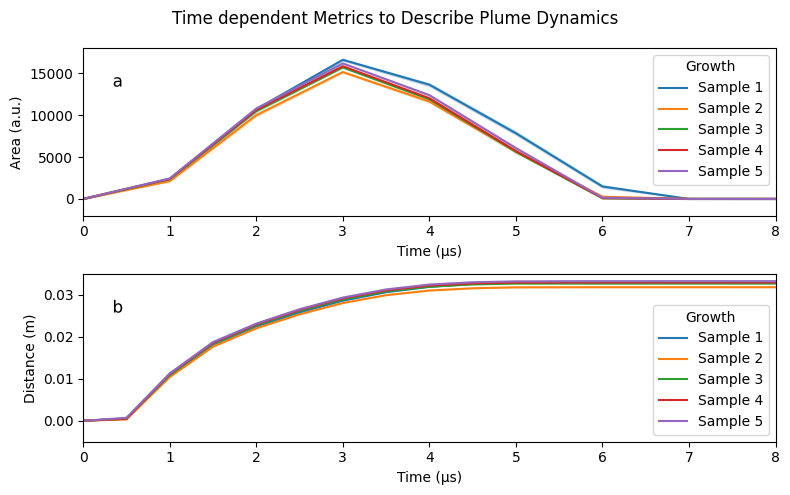

In [119]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))
df_filtered = df_frame_metrics_target[df_frame_metrics_target['Time (µs)'].isin(range(0, 9))]
lineplot = sns.lineplot(x="Time (µs)", y="Area (a.u.)", hue='Growth', data=df_filtered, ax=axes[0])
axes[0].set_xlim(0, 8)
axes[0].set_ylim(-2000, 18000)
labelfigs(axes=axes[0], number=0, size=12, style='bw', inset_fraction=(0.2, 0.05))

lineplot = sns.lineplot(x="Time (µs)", y="Distance (m)", hue='Growth', data=df_frame_metrics_target, ax=axes[1])
axes[1].set_xlim(0, 8)
axes[1].set_ylim(-0.005, 0.035)
labelfigs(axes=axes[1], number=1, size=12, style='bw', inset_fraction=(0.2, 0.05))

plt.suptitle('Time dependent Metrics to Describe Plume Dynamics')
plt.tight_layout()
plt.savefig('../figures/3_Plume_metric_average.png', dpi=600)
plt.show()

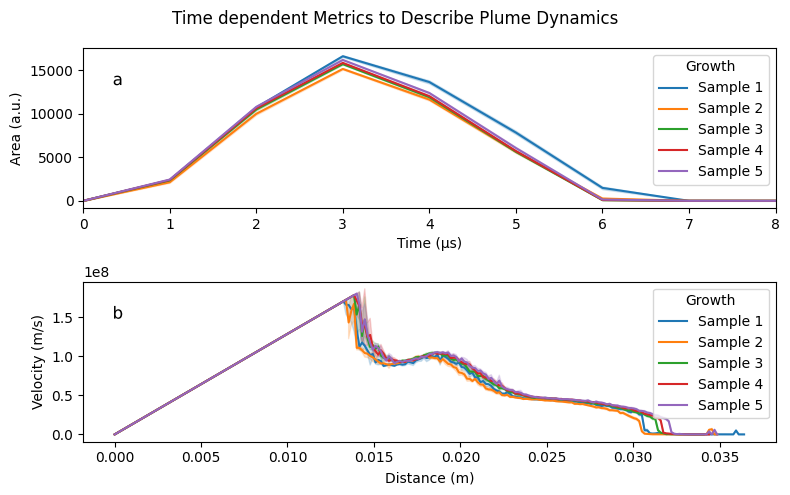

In [92]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))
df_filtered = df_frame_metrics_target[df_frame_metrics_target['Time (µs)'].isin(range(0, 9))]
lineplot = sns.lineplot(x="Time (µs)", y="Area (a.u.)", hue='Growth', data=df_filtered, ax=axes[0])
axes[0].set_xlim(0, 8)
labelfigs(axes=axes[0], number=0, size=12, style='bw', inset_fraction=(0.2, 0.05))

lineplot = sns.lineplot(x="Distance (m)", y="Velocity (m/s)", hue='Growth', data=df_frame_metrics_target, ax=axes[1])
labelfigs(axes=axes[1], number=1, size=12, style='bw', inset_fraction=(0.2, 0.05))

plt.suptitle('Time dependent Metrics to Describe Plume Dynamics')
plt.tight_layout()
plt.savefig('../figures/2_Plume_metric_summary.png', dpi=600)
plt.show()

C:\Users\yig319\AppData\Local\Temp\ipykernel_56644\2998329031.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles1, labels1 = lineplot1.get_legend().legendHandles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
C:\Users\yig319\AppData\Local\Temp\ipykernel_56644\2998329031.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles1, labels1 = lineplot1.get_legend().legendHandles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
C:\Users\yig319\AppData\Local\Temp\ipykernel_56644\2998329031.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles1, labels1 = lineplot1.get_legend().legendHandles, 

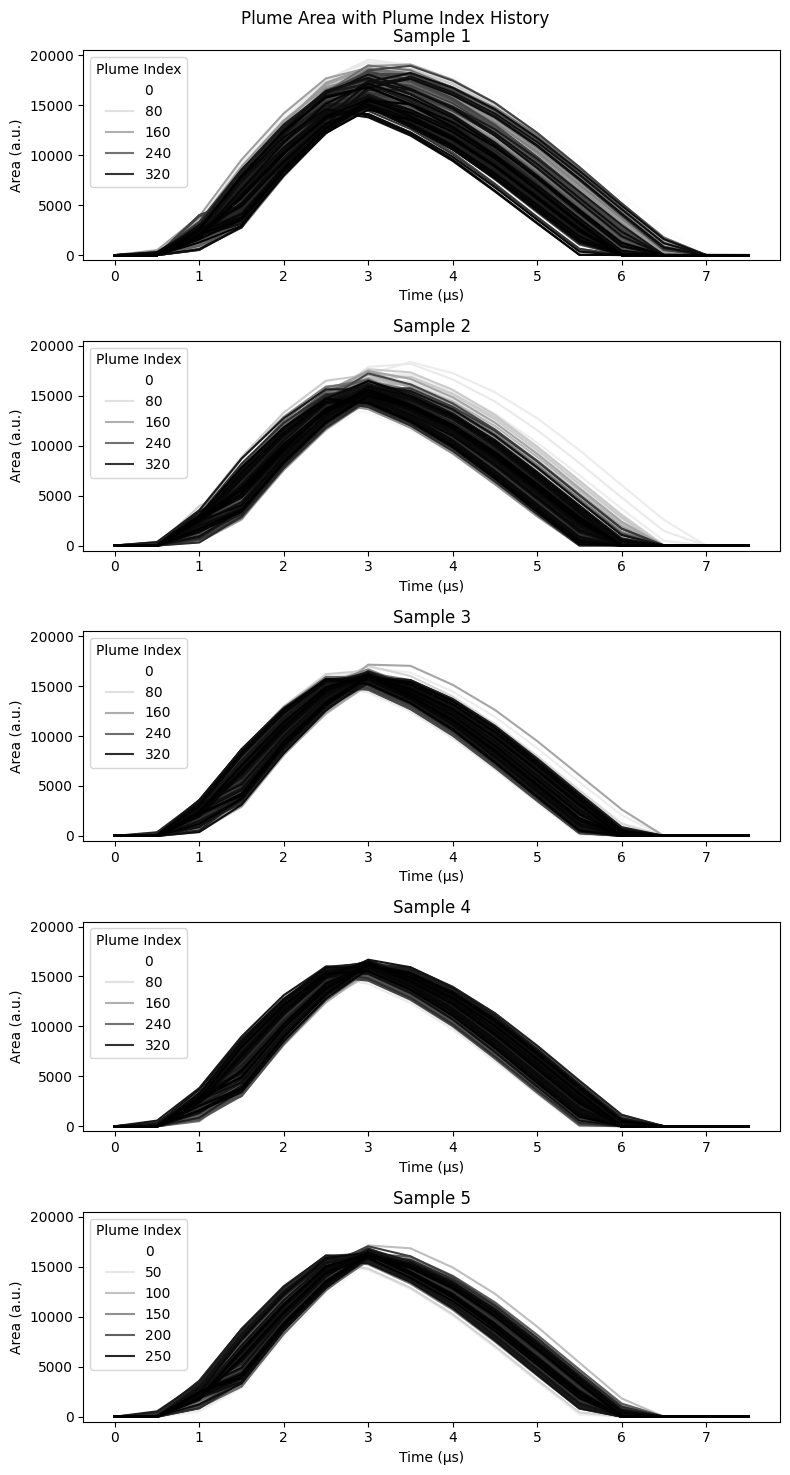

In [93]:
df_sample = df_frame_metrics_target[(df_frame_metrics_target['Time (µs)'] >= 0) & (df_frame_metrics_target['Time (µs)'] < 8)] 

fig, axes = plt.subplots(5, 1, figsize=(8, 3*5))
for ax, growth in zip(axes, growth_names):
    
    # Create the first lineplot
    lineplot1 = sns.lineplot(x="Time (µs)", y="Area (a.u.)", hue="Plume Index", data=df_sample[df_sample['Growth'] == growth], ax=ax, palette='Greys')

    # Get the handles and labels specifically for the first plot (Plume Index)
    handles1, labels1 = lineplot1.get_legend().legendHandles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
    legend1 = ax.legend(handles=handles1, labels=labels1, title="Plume Index", loc='upper left')

    ax.set_title(growth)
    # ax.set_xlim(0, 15)
    ax.set_ylim(-500, 20500)
    ax.legend
plt.suptitle("Plume Area with Plume Index History")
plt.tight_layout()
plt.show()

### 2.3 Violin Plot of Plume Max Area and Incident Velocity Statics

C:\Users\yig319\AppData\Local\Temp\ipykernel_56644\3463760755.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Growth', y='Max Area (a.u.)', data=df_plume_metrics_target, width=0.9, ax=axes[0], palette='deep')
C:\Users\yig319\AppData\Local\Temp\ipykernel_56644\3463760755.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Growth', y='Incident Velocity (m/s)', data=df_plume_metrics_target, width=0.9, ax=axes[1], palette='deep')


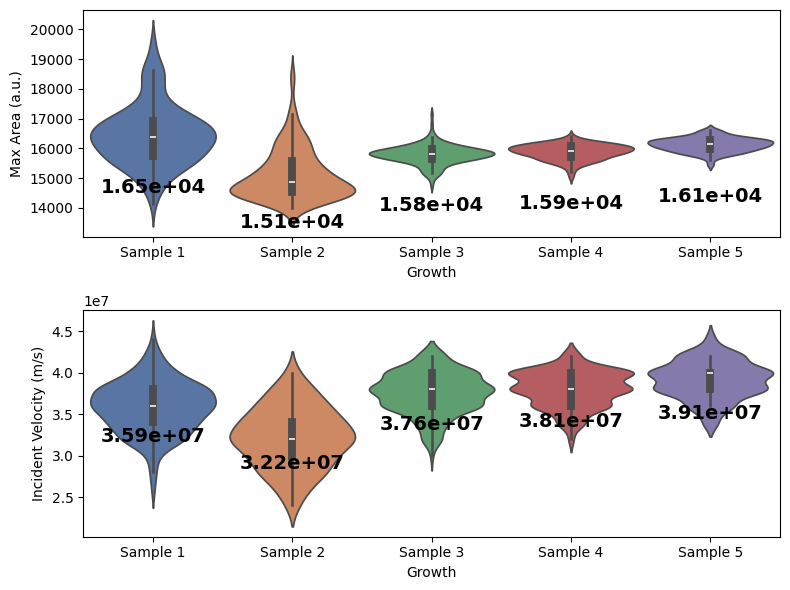

In [97]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
sns.violinplot(x='Growth', y='Max Area (a.u.)', data=df_plume_metrics_target, width=0.9, ax=axes[0], palette='deep')
mean_max_area = df_plume_metrics_target.groupby('Growth')['Max Area (a.u.)'].mean()
label_violinplot(axes[0], mean_max_area, label_type='average_value', text_pos='center', value_format='scientific',
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})

sns.violinplot(x='Growth', y='Incident Velocity (m/s)', data=df_plume_metrics_target, width=0.9, ax=axes[1], palette='deep')
mean_incident_velocity = df_plume_metrics_target.groupby('Growth')['Incident Velocity (m/s)'].mean()
label_violinplot(axes[1], mean_incident_velocity, label_type='average_value', text_pos='center', value_format='scientific',
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})


# df_plume_metrics_target = df_plume_metrics[df_plume_metrics['Growth'].isin(growth_names)]
# colors = sns.color_palette("viridis", as_cmap=False, n_colors=df_plume_metrics_target['Growth'].nunique())

# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# sns.violinplot(x='Growth', y='incident_velocity', data=df_plume_metrics_target, width=0.9, ax=ax, palette='deep')
# mean_incident_velocity = df_plume_metrics_target.groupby('Growth')['incident_velocity'].mean()
# label_violinplot(ax, mean_incident_velocity, label_type='average_value', text_pos='center', value_format='scientific', 
#                  offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
# ax.set_title('Plume Incident Velocity')
# plt.tight_layout()
# plt.show()


plt.tight_layout()
plt.savefig('../figures/4_Plume_metrics_violinplot.png', dpi=600)
plt.show()